In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# OLD DATA: Import, set index
# df = pd.read_csv('/home/frankmuci/code/frankmuci/venezuela_fx/venezuela_fx/data/working_df.csv')
# df.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
# df['Date'] = pd.to_datetime(df['Date'] )
# df.set_index('Date', inplace=True)

# NEW DATA from Joe: Read and set index :)
df = pd.read_csv('/home/frankmuci/code/frankmuci/venezuela_fx/venezuela_fx/data/friday_feeling_df.csv')
df.rename(columns={'date':'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'] )
df.set_index('Date', inplace=True)

In [3]:
# FEATURE ENGINEERING
cols_to_transform = ['BM (BsS)', 'M2 (BsS)', 'Private_Sector_Credit', 'Consumer_Price_Index_CPI', 'CPI_Transportation', 'Stock_Market']
log_col_names = []
usd_col_names = []
log_col_names_diff = []
usd_col_names_diff = []
usd_col_names_log = []

for col in cols_to_transform:
    log_col_names.append(f'log_{col}')
    usd_col_names.append(f'usd_{col}')
    log_col_names_diff.append(f'log_{col}_diff')
    usd_col_names_diff.append(f'usd_{col}_diff')
    usd_col_names_log.append(f'usd_{col}_log')
    
for idx, col in enumerate(cols_to_transform):
    df[log_col_names[idx]] = np.log(df[col]) # Log
    df[usd_col_names[idx]] = df[col]/df['Dolartoday'] # Deflate by FX
    df[log_col_names_diff[idx]] = df[log_col_names[idx]].diff()
    df[usd_col_names_diff[idx]] = df[usd_col_names[idx]].diff()
    df[usd_col_names_log[idx]] = np.log(df[usd_col_names[idx]]).diff()

In [4]:
# TARGET ENGINEERING
df['Dolartoday_log'] = np.log(df.Dolartoday)
df['Dolartoday_log_diff'] = df['Dolartoday_log'].diff()

In [28]:
df.shape

(51577, 7)

In [5]:
# fig, axs = plt.subplots(4,3, figsize=(20,20))
# axs = axs.flatten()
# for idx, col in enumerate(list(usd_col_names_log)):
# #     axs[idx].plot(df.resample('m').first()[col])
#     axs[idx].plot(df[col])
#     axs[idx].set_title(col)

In [6]:
# plt.plot(df.usd_Consumer_Price_Index_CPI)

## Select Features, Train Test Split

In [7]:
# SELECT FEATURES
df_original = df.copy()
relevant_cols = usd_col_names_log.copy()
df = df[relevant_cols]

In [8]:
# SCALE FEATURES
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [9]:
df['Dolartoday_log_diff'] = df_original['Dolartoday_log_diff'] 
relevant_cols.append('Dolartoday_log_diff')
column_count = len(relevant_cols)

In [10]:
# TRAIN TEST SPLIT
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[int(n*0.3):int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Imports and Code for Windowing 

In [11]:
import tensorflow as tf

2021-12-02 09:46:49.532095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 09:46:49.532135: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, 
                 val_df=val_df, test_df=test_df, label_columns=['Dolartoday_log_diff']):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [13]:
window_size = 65 * 24
distance = 30 * 24
window = WindowGenerator(window_size, 1, distance)

## The model

In [14]:
# Inspect Shape of Data Samples
x_sample, y_sample = next(iter(window.train))
print(x_sample.shape)
print(y_sample.shape)

(32, 1560, 7)
(32, 1, 1)


2021-12-02 09:46:51.246807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-02 09:46:51.246897: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-02 09:46:51.246939: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-SBD4PR3): /proc/driver/nvidia/version does not exist
2021-12-02 09:46:51.248015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, Normalization, Masking, GRU, Dropout, LSTM

def init_model():
    model = Sequential()
    model.add(LSTM(units=32, activation='tanh', input_shape=(window_size,column_count), return_sequences=False))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1, activation="linear"))
    
    model.compile(loss='mae', optimizer='adam', metrics=['mape', 'mse', 'mae'])
    return model

In [16]:
test_model = init_model()

In [25]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,665
Trainable params: 5,665
Non-trainable params: 0
_________________________________________________________________


In [17]:
test_model.fit(window.train, batch_size=32, epochs=5, verbose=1)

Epoch 1/5
574/574 [==============================] - 461s 801ms/step - loss: 0.0033 - mape: 216087.6562 - mse: 4.0030e-05 - mae: 0.0033
Epoch 2/5
574/574 [==============================] - 419s 729ms/step - loss: 0.0022 - mape: 136967.5625 - mse: 8.7614e-06 - mae: 0.0022
Epoch 3/5
574/574 [==============================] - 462s 805ms/step - loss: 0.0018 - mape: 91428.4609 - mse: 5.8070e-06 - mae: 0.0018
Epoch 4/5
574/574 [==============================] - 451s 785ms/step - loss: 0.0016 - mape: 82705.0703 - mse: 4.9967e-06 - mae: 0.0016
Epoch 5/5
574/574 [==============================] - 448s 780ms/step - loss: 0.0016 - mape: 80084.4688 - mse: 5.0289e-06 - mae: 0.0016


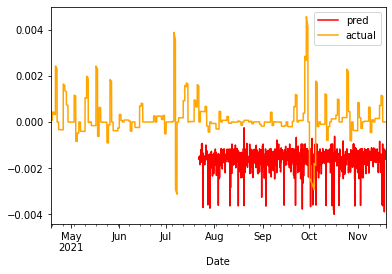

In [19]:
# PLOT IN DIFFERENCED UNITS
predictions = test_model.predict(window.test)
series_pred = pd.Series(predictions[:, 0])
series_pred.index = test_df.iloc[95*24 - 1:].index
series_pred.plot(label = 'pred', color='red')
test_df['Dolartoday_log_diff'].plot(label = 'actual', color = 'orange')
plt.legend()

In [20]:
# Log Change Prediction Series
series_pred_shft = series_pred.shift(30, freq='D')
pred_timestamp_count = series_pred_shft.shape[0]
first_pred_timestamp = series_pred_shft.index[0]
last_pred_timestamp = series_pred_shft.index[-1]
print('predictions for', first_pred_timestamp, 'to', last_pred_timestamp)

predictions for 2021-08-21 02:00:00 to 2021-12-19 00:00:00


In [21]:
# Data of base log series to add prediction to 
delta = datetime.timedelta(30)
base_log_series = np.log(df_original['Dolartoday'])
base_log_series = base_log_series[first_pred_timestamp - delta:]
base_log_series_shft = base_log_series.shift(30, freq='D')

In [22]:
# Complete prediction 
comp_pred = series_pred_shft + base_log_series_shft

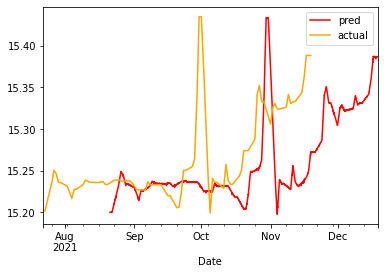

In [23]:
# PLOT IN LOG UNITS
comp_pred.plot(label = 'pred', color='red')
base_log_series.plot(label = 'actual', color = 'orange')
plt.legend()

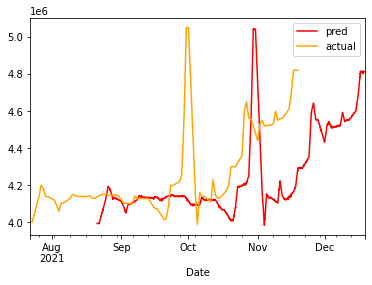

In [24]:
comp_pred_orig = np.exp(comp_pred)
base_log_series_orig = np.exp(base_log_series)
comp_pred_orig.plot(label = 'pred', color='red')
base_log_series_orig.plot(label = 'actual', color = 'orange')
plt.legend()

In [ ]:
# Calculate average absolute % error in original units


In [ ]:
from scipy.stats import pearsonr
pearsonr(test_df.iloc[94:,-1], series_pred)

In [ ]:
# Check if it is overfitting
predictions = test_model.predict(window.train)
series_pred = pd.Series(predictions[:, 0])
series_pred.index = train_df.iloc[94:].index
series_pred.plot(label = 'pred')
train_df['Dolartoday_log_diff'].plot(label = 'actual', color = 'orange')
plt.legend()

In [ ]:
pearsonr(train_df.iloc[94:,-1], series_pred)

In [ ]:
series_pred